In [1]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
import os
import torch
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import numpy as np
import cv2
from particle_detection.autoencoder.model import create_autoencoder
from particle_detection.data.dataset import create_dataloaders

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [4]:
data_dir = "/home/blah-buttery/nanoparticles/images/normal"
image_size = (1024, 1024)
batch_size = 1

train_loader, test_loader = create_dataloaders(data_dir=data_dir, image_size=image_size, batch_size=batch_size)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=128):  # Set in_channels=1 for grayscale
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 1024 -> 512
            nn.ReLU(),
            nn.BatchNorm2d(64),  # Add BatchNorm
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 512 -> 256
            nn.ReLU(),
            nn.BatchNorm2d(128),  # Add BatchNorm
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256 -> 128
            nn.AdaptiveAvgPool2d((8, 8)),  # Reduce spatial dimensions further
            nn.ReLU(),
            nn.BatchNorm2d(256)   # Add BatchNorm
        )
        
        # Latent space
        self.flattened_dim = 256 * 8 * 8  # Adjusted for adaptive pooling
        self.fc_mu = nn.Linear(self.flattened_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_dim, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, self.flattened_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64 -> 128
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128 -> 256
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1),  # 256 -> 512
            nn.ReLU(),
            nn.ConvTranspose2d(4, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # 512 -> 1024
            nn.Sigmoid()
        )


    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick: z = mu + std * epsilon
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, debug=False):
        if torch.isnan(x).any():
            print("[ERROR] NaN detected in input!")
            raise ValueError("NaN detected in input tensor.")
    
        # Encode
        encoded = self.encoder(x)
    
        if torch.isnan(encoded).any():
            print("[ERROR] NaN detected in encoded tensor!")
            raise ValueError("NaN detected in encoded tensor.")
    
        encoded_flat = encoded.view(encoded.size(0), -1)
        
        # Latent variables
        mu = self.fc_mu(encoded_flat)
        logvar = self.fc_logvar(encoded_flat)
        #logvar = torch.clamp(logvar, min=-10, max=10)  # Avoid too large/small values

    
        if torch.isnan(mu).any() or torch.isnan(logvar).any():
            print("[ERROR] NaN detected in latent variables!")
            raise ValueError("NaN detected in latent space.")
    
        z = self.reparameterize(mu, logvar)
    
        # Decode
        decoded_flat = self.fc_decoder(z)
        decoded = decoded_flat.view(-1, 256, 8, 8)
        x_reconstructed = self.decoder(decoded)
    
        if torch.isnan(x_reconstructed).any():
            print("[ERROR] NaN detected in reconstructed output!")
            raise ValueError("NaN detected in reconstructed tensor.")
        #print(f"Final reconstructed shape: {x_reconstructed.shape}")

    
        return x_reconstructed, mu, logvar
    '''
    def forward(self, x, debug=False):
        if debug:
            print(f"Input shape: {x.shape}")
        
        # Encode
        encoded = self.encoder(x)
        if debug:
            print(f"Encoded shape: {encoded.shape}")
        encoded_flat = encoded.view(encoded.size(0), -1)
        
        # Latent variables
        mu = self.fc_mu(encoded_flat)
        logvar = self.fc_logvar(encoded_flat)
        z = self.reparameterize(mu, logvar)

        # Decode
        decoded_flat = self.fc_decoder(z)
        decoded = decoded_flat.view(-1, 256, 8, 8)  # Adjusted to match adaptive pooling
        if debug:
            print(f"Decoded (before upsampling) shape: {decoded.shape}")
        x_reconstructed = self.decoder(decoded)
        if debug:
            print(f"Reconstructed shape: {x_reconstructed.shape}")

        # Ensure reconstruction matches input size
        x_reconstructed = F.interpolate(x_reconstructed, size=x.shape[2:], mode="bilinear", align_corners=False)
        if debug:
            print(f"Final reconstructed shape (after interpolation): {x_reconstructed.shape}")

        return x_reconstructed, mu, logvar
    '''

# Loss function for VAE
'''
def vae_loss(recon_x, x, mu, logvar):
    """
    Computes the VAE loss as the sum of reconstruction loss and KL divergence.
    :param recon_x: Reconstructed input.
    :param x: Original input.
    :param mu: Mean of the latent distribution.
    :param logvar: Log variance of the latent distribution.
    """
    # Reconstruction loss
    recon_loss = F.l1_loss(recon_x, x, reduction='sum') / x.size(0)
    
    # KL divergence
    #kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp().clamp(min=1e-8))

    return recon_loss + kl_div
'''
def vae_loss(recon_x, x, mu, logvar, beta=0.1):  # Reduce KL effect
    recon_loss = F.l1_loss(recon_x, x, reduction='sum') / x.size(0)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div
def create_vae(in_channels=1):
    """
    Creates and returns a Variational Autoencoder (VAE) instance.
    """
    model = VAE(in_channels=in_channels)
    def weights_init(m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    model.apply(weights_init)
    return model


In [ ]:
for batch in train_loader:
    print(batch.shape)
    break


In [6]:
def train_vae(model, train_loader, optimizer, num_epochs, accumulation_steps=1, device="cuda"):
    from torch.cuda.amp import GradScaler, autocast
    import traceback

    scaler = GradScaler()  # Updated to default usage (no string "cuda" here)
    model.to(device)
    model.train()
    torch.autograd.set_detect_anomaly(True)
    print("[INFO] Anomaly detection enabled.")
    training_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        for i, batch in enumerate(train_loader):
            try:
                batch = batch.to(device)

                # Clear GPU cache to avoid memory fragmentation
                torch.cuda.empty_cache()

                # Mixed precision training
                optimizer.zero_grad(set_to_none=True)
                with torch.amp.autocast(device_type='cuda', dtype=torch.float16):  # Corrected usage
                    reconstructed, mu, logvar = model(batch)
                    loss = vae_loss(reconstructed, batch, mu, logvar)
                    loss = loss / accumulation_steps  # Scale loss for accumulation

                # Backward pass
                scaler.scale(loss).backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                # Perform optimizer step every accumulation_steps
                if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)

                # Accumulate loss before deleting tensors
                train_loss += loss.item() * accumulation_steps

                # Manually delete large tensors after step
                del loss, reconstructed, mu, logvar
                torch.cuda.empty_cache()

            except RuntimeError as e:
                # Log the error with traceback
                print(f"[ERROR] RuntimeError at epoch {epoch + 1}, batch {i + 1}: {str(e)}")
                traceback.print_exc()

                # Optional: continue training or break
                # Uncomment the line below to stop training on error
                # raise

                # Skip the current batch to allow training to continue
                continue

        # Force memory cleanup at end of each epoch
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

        avg_loss = train_loss / len(train_loader.dataset)
        training_losses.append(avg_loss)
        print(f"[INFO] Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    print("[INFO] Training complete!")


In [8]:
# Define model, optimizer, and dataloader
torch.cuda.empty_cache()
vae = VAE(in_channels=1, latent_dim=128)
vae = nn.DataParallel(vae).to(device)
#optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)  # Instead of 1e-3

# Train the model
train_vae(model=vae, train_loader=train_loader, optimizer=optimizer, num_epochs=20, accumulation_steps=4, device="cuda")

/tmp/ipykernel_7826/730261795.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Updated to default usage (no string "cuda" here)


[INFO] Anomaly detection enabled.
[INFO] Epoch [1/20], Loss: 195340.5957
[INFO] Epoch [2/20], Loss: 241118.9053
[INFO] Epoch [3/20], Loss: 202894.3809
[INFO] Epoch [4/20], Loss: 217814.6699
[INFO] Epoch [5/20], Loss: 243244.0859
[INFO] Epoch [6/20], Loss: 203474.5439
[INFO] Epoch [7/20], Loss: 193983.3408
[INFO] Epoch [8/20], Loss: 255070.1309
[INFO] Epoch [9/20], Loss: 197709.8613
[INFO] Epoch [10/20], Loss: 243385.5254
[INFO] Epoch [11/20], Loss: 285879.6758
[INFO] Epoch [12/20], Loss: 308332.6104
[INFO] Epoch [13/20], Loss: 219866.1885
[INFO] Epoch [14/20], Loss: 206808.7393
[INFO] Epoch [15/20], Loss: 177986.1680
[ERROR] RuntimeError at epoch 16, batch 4: Function 'AddmmBackward0' returned nan values in its 1th output.
[ERROR] RuntimeError at epoch 16, batch 5: Function 'CudnnBatchNormBackward0' returned nan values in its 0th output.


Traceback (most recent call last):
  File "/tmp/ipykernel_7826/730261795.py", line 29, in train_vae
    scaler.scale(loss).backward()
  File "/home/blah-buttery/particle_detection/.venv/lib/python3.10/site-packages/torch/_tensor.py", line 626, in backward
    torch.autograd.backward(
  File "/home/blah-buttery/particle_detection/.venv/lib/python3.10/site-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/home/blah-buttery/particle_detection/.venv/lib/python3.10/site-packages/torch/autograd/graph.py", line 823, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
RuntimeError: Function 'AddmmBackward0' returned nan values in its 1th output.
Traceback (most recent call last):
  File "/tmp/ipykernel_7826/730261795.py", line 29, in train_vae
    scaler.scale(loss).backward()
  File "/home/blah-buttery/particle_detection/.venv/lib/python3.10/site-packages/torch/_tensor.py

[INFO] Epoch [16/20], Loss: 237806.2930
[ERROR] RuntimeError at epoch 17, batch 3: Function 'AddmmBackward0' returned nan values in its 1th output.


Traceback (most recent call last):
  File "/tmp/ipykernel_7826/730261795.py", line 29, in train_vae
    scaler.scale(loss).backward()
  File "/home/blah-buttery/particle_detection/.venv/lib/python3.10/site-packages/torch/_tensor.py", line 626, in backward
    torch.autograd.backward(
  File "/home/blah-buttery/particle_detection/.venv/lib/python3.10/site-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/home/blah-buttery/particle_detection/.venv/lib/python3.10/site-packages/torch/autograd/graph.py", line 823, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
RuntimeError: Function 'AddmmBackward0' returned nan values in its 1th output.


[INFO] Epoch [17/20], Loss: 203483.4375
[ERROR] RuntimeError at epoch 18, batch 7: Function 'CudnnBatchNormBackward0' returned nan values in its 0th output.
[INFO] Epoch [18/20], Loss: 214124.2051


Traceback (most recent call last):
  File "/tmp/ipykernel_7826/730261795.py", line 29, in train_vae
    scaler.scale(loss).backward()
  File "/home/blah-buttery/particle_detection/.venv/lib/python3.10/site-packages/torch/_tensor.py", line 626, in backward
    torch.autograd.backward(
  File "/home/blah-buttery/particle_detection/.venv/lib/python3.10/site-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/home/blah-buttery/particle_detection/.venv/lib/python3.10/site-packages/torch/autograd/graph.py", line 823, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
RuntimeError: Function 'CudnnBatchNormBackward0' returned nan values in its 0th output.


[INFO] Epoch [19/20], Loss: 193574.2441
[INFO] Epoch [20/20], Loss: 199295.8193
[INFO] Training complete!


Type of reconstructed_img: <class 'torch.Tensor'>
Shape of reconstructed_img: torch.Size([1, 1, 1024, 1024])


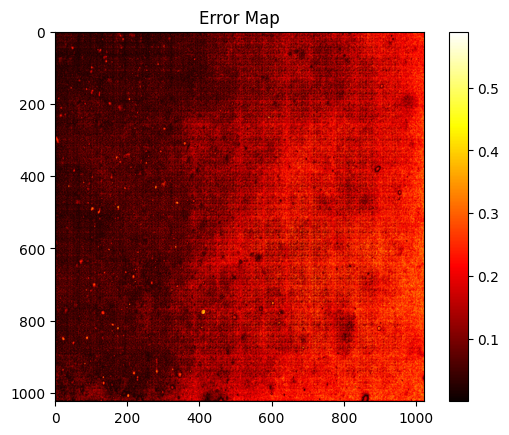

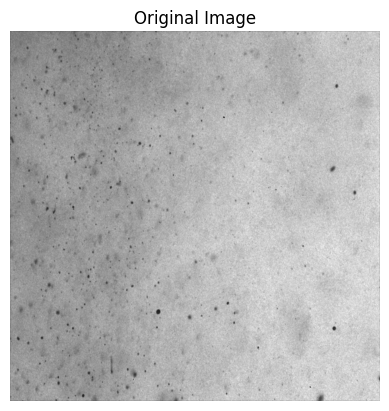

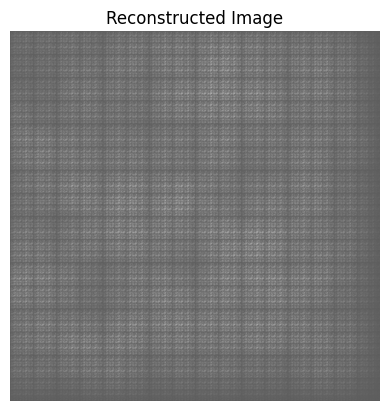

In [9]:
import matplotlib.pyplot as plt

sample_img = next(iter(test_loader))
sample_img = sample_img.to(device)

# Forward pass sample_img through our trained model
with torch.no_grad():
    # Unpack the tuple returned by the model
    reconstructed_img, _, _ = vae(sample_img)  # Unpack reconstructed_img, mu, logvar

# Debugging: Ensure `reconstructed_img` is valid
print(f"Type of reconstructed_img: {type(reconstructed_img)}")
print(f"Shape of reconstructed_img: {reconstructed_img.shape if isinstance(reconstructed_img, torch.Tensor) else None}")

# Ensure `reconstructed_img` is clamped correctly
if isinstance(reconstructed_img, torch.Tensor):
    reconstructed_img = torch.clamp(reconstructed_img, min=0, max=1)
else:
    raise ValueError("Expected `reconstructed_img` to be a Tensor but got None or invalid type.")

# Calculate error map
error_map = torch.abs(sample_img - reconstructed_img).mean(dim=1).cpu().numpy()
error_map_image = error_map[0]

# Display error map
plt.imshow(error_map_image, cmap="hot")
plt.colorbar()
plt.title("Error Map")
plt.show()

# Function to display images
def display_image(tensor, title="Image"):
    img = tensor.cpu().detach().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1]
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Display original and reconstructed images
display_image(sample_img[0], title="Original Image")
display_image(reconstructed_img[0], title="Reconstructed Image")


In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(training_losses)), training_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Over Epochs")
plt.show()
